In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import time
from typing import List, Union
from tqdm import tqdm
from datetime import datetime
import yfinance as yf

/Users/christopherli/ML/Trading/LSTM/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31", auto_adjust=False)
data.index = pd.to_datetime(data.index)

[*********************100%***********************]  1 of 1 completed


In [3]:
lookback = 24
horizon = 1

close = data["Close"]
returns = np.log(close).diff().dropna().values.reshape(-1, 1)


In [10]:
training_len = int(np.ceil(len(returns) * 0.90))
train_returns = returns[:training_len]
test_returns = returns[training_len - lookback:]

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_returns)
scaled_test = scaler.transform(test_returns)

In [11]:
X_train, y_train = [], []
for i in range(lookback, len(scaled_train) - horizon + 1):
    X_train.append(scaled_train[i - lookback:i, 0])
    y_train.append(scaled_train[i + horizon - 1, 0])

X_train = np.array(X_train).reshape(-1, lookback, 1)
y_train = np.array(y_train)

In [12]:
X_test, y_test = [], []
for i in range(lookback, len(scaled_test) - horizon + 1):
    X_test.append(scaled_test[i - lookback:i, 0])
    y_test.append(scaled_test[i + horizon - 1, 0])

X_test = np.array(X_test).reshape(-1, lookback, 1)
y_test = np.array(y_test)

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

/Users/christopherli/ML/Trading/LSTM/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.summary()
model.compile(optimizer="adam", loss="mae", metrics=[keras.metrics.RootMeanSquaredError(), "r2_score"])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,109 (684.02 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 116,740 (456.02 KB)

In [17]:
training = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.7030 - r2_score: 0.0261 - root_mean_squared_error: 0.9900
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7015 - r2_score: 0.0380 - root_mean_squared_error: 0.9839
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6991 - r2_score: 0.0332 - root_mean_squared_error: 0.9864
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6989 - r2_score: 0.0468 - root_mean_squared_error: 0.9794
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6984 - r2_score: 0.0520 - root_mean_squared_error: 0.9767
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7007 - r2_score: 0.0410 - root_mean_squared_error: 0.9824
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6947 - r2_score: 0.0622 - root_mean_squared_error: 0.9715
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6979 - r2_score: 0.0485 - root_mean_squared_error: 0.9785
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

In [18]:
predictions = model.predict(X_test)
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [34]:
train = data[:training_len].copy()
test = data[training_len:].copy()

predictions_flat = predictions_actual.flatten()

# 2️⃣ Reconstruct predicted prices from last training price
last_train_price = float(train["Close"].iloc[-1])
pred_cum_returns = np.cumsum(predictions_flat)
pred_prices = last_train_price * np.exp(pred_cum_returns)

# 3️⃣ Align test dataframe exactly to predictions
num_test_seq = X_test.shape[0]
test_aligned = test.iloc[:num_test_seq].copy().reset_index(drop=True)  # reset index to avoid misalignment
test_aligned["Predictions"] = pred_prices




/var/folders/2b/zvv8556n7vbfkz5g_xhjv4mc0000gn/T/ipykernel_16301/434097207.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_train_price = float(train["Close"].iloc[-1])


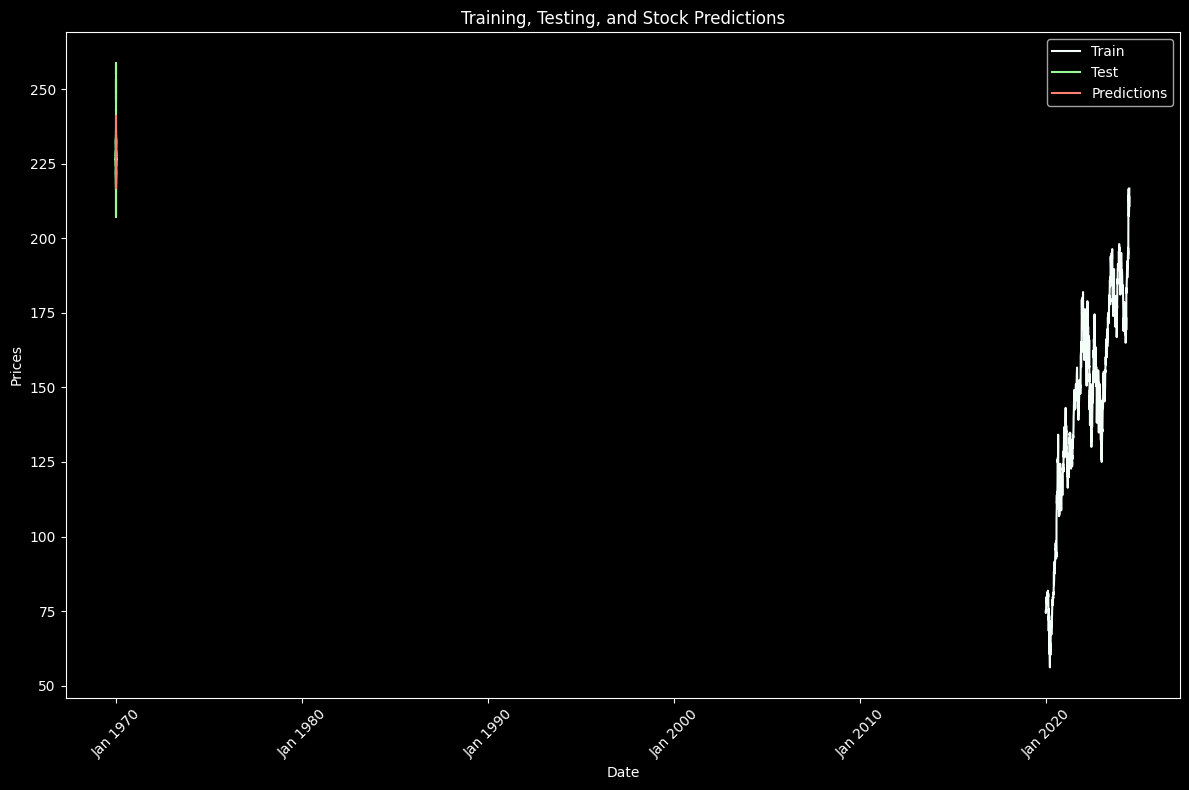

In [35]:
train.index = pd.to_datetime(train.index)
test_aligned.index = pd.to_datetime(test_aligned.index)
plt.style.use('dark_background')

# 5️⃣ Plot
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train.index, train["Close"], color="mintcream", label="Train")
ax.plot(test_aligned.index, test_aligned["Close"], color="palegreen", label="Test")
ax.plot(test_aligned.index, test_aligned["Predictions"], color="salmon", label="Predictions")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title("Training, Testing, and Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

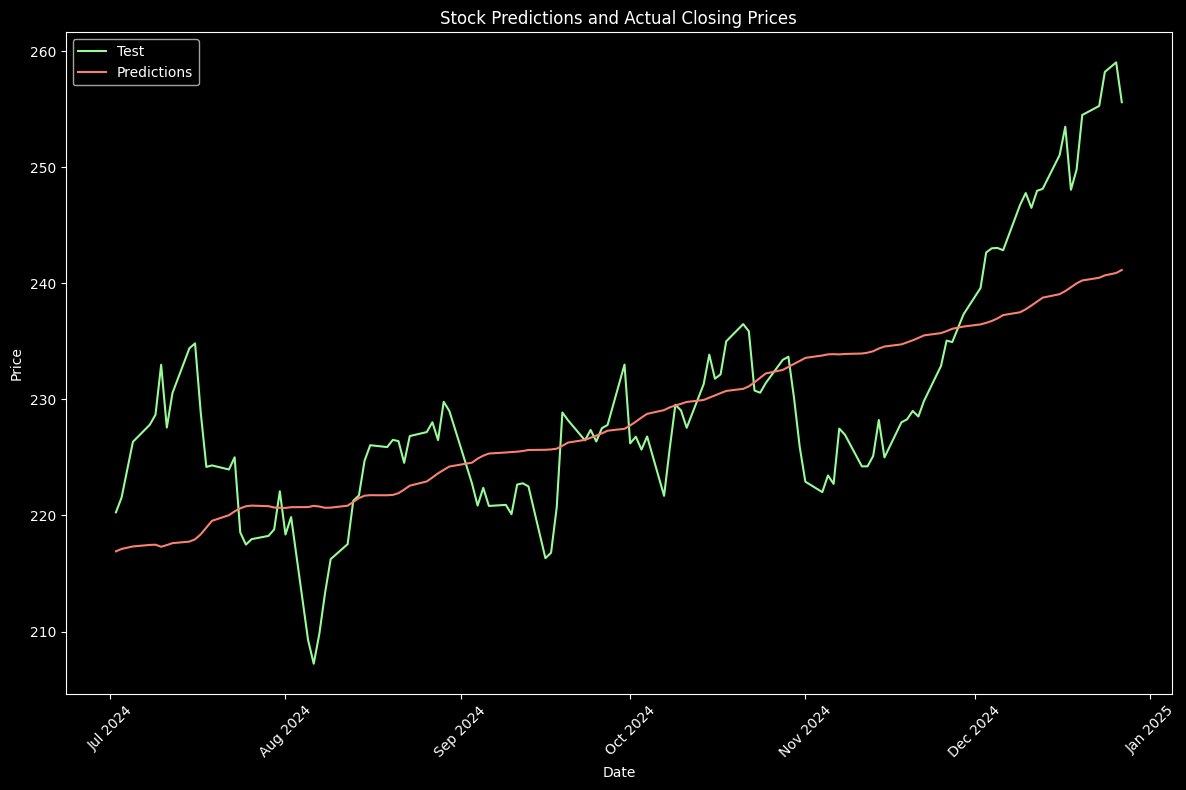

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot actual vs predicted prices
ax.plot(test_aligned.index, test_aligned["Close"], color="palegreen", label="Test")
ax.plot(test_aligned.index, test_aligned["Predictions"], color="salmon", label="Predictions")

# Format the x-axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.title("Stock Predictions and Actual Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

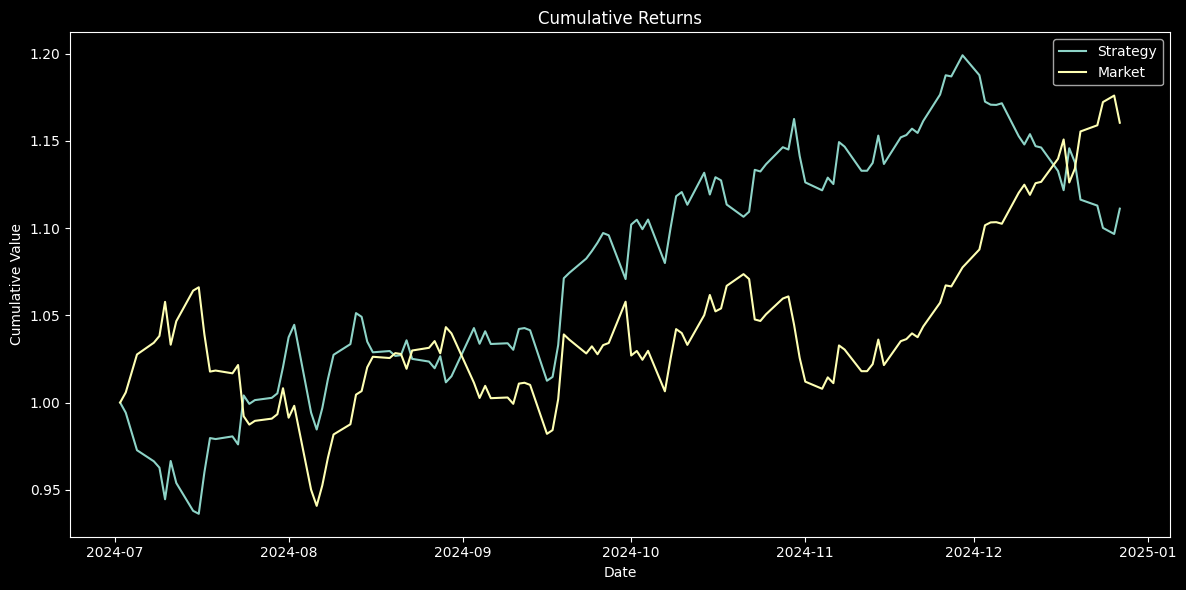

Profit Factor: 1.2157876912016434
Cumulative Return: 0.11111790362522966
Sharpe Ratio: 1.1520851430919707
Max Drawdown: 0.08542428023537704


In [44]:
# 1️⃣ Flatten predictions to 1D
pred_prices_flat = pred_prices.flatten()  # shape (num_test_samples,)

# 2️⃣ Align test DataFrame exactly to number of predictions
num_test_seq = len(pred_prices_flat)
test_aligned = test.iloc[:num_test_seq].copy()  # slice test rows
test_aligned = test_aligned.copy()  # avoid SettingWithCopyWarning

# 3️⃣ Assign predictions as a 1D Series
test_aligned["Predictions"] = pred_prices_flat  # no index reset needed

# ✅ Make sure Close is a Series, not DataFrame
close_series = test_aligned["Close"].squeeze()  # ensures 1D

# 4️⃣ Generate trading signals safely
test_aligned["Signal"] = np.where(pred_prices_flat > close_series, 1, -1)

# 5️⃣ Calculate returns and strategy returns
test_aligned["Return"] = close_series.pct_change()
test_aligned["Strategy_Return"] = test_aligned["Signal"].shift(1) * test_aligned["Return"]

# 6️⃣ Performance metrics
gross_profit = test_aligned.loc[test_aligned["Strategy_Return"] > 0, "Strategy_Return"].sum()
gross_loss = -test_aligned.loc[test_aligned["Strategy_Return"] < 0, "Strategy_Return"].sum()
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan

test_aligned["Cumulative_Strategy"] = (1 + test_aligned["Strategy_Return"].fillna(0)).cumprod()
test_aligned["Cumulative_Market"] = (1 + test_aligned["Return"].fillna(0)).cumprod()
cumulative_return = test_aligned["Cumulative_Strategy"].iloc[-1] - 1

periods_per_year = 252
mean_return = test_aligned["Strategy_Return"].mean()
std_return = test_aligned["Strategy_Return"].std()
sharpe_ratio = (mean_return / std_return) * np.sqrt(periods_per_year) if std_return != 0 else np.nan

equity = test_aligned["Cumulative_Strategy"]
running_max = equity.cummax()
drawdown = (running_max - equity) / running_max
max_drawdown = drawdown.max()

# 7️⃣ Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(test_aligned.index, test_aligned["Cumulative_Strategy"], label="Strategy")
plt.plot(test_aligned.index, test_aligned["Cumulative_Market"], label="Market")
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.tight_layout()
plt.show()

# 8️⃣ Print metrics
print("Profit Factor:", profit_factor)
print("Cumulative Return:", cumulative_return)
print("Sharpe Ratio:", sharpe_ratio)
print("Max Drawdown:", max_drawdown)


In [56]:

# -----------------------------
# Function to train an LSTM
# -----------------------------
def train_LSTM(model, X, y, epochs=10, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# -----------------------------
# Function to compute performance metrics
# -----------------------------
def get_factors(test_aligned):
    # Ensure Close is 1D
    close_series = test_aligned["Close"].squeeze()
    
    # Signals: buy if predicted > actual
    test_aligned["Signal"] = np.where(test_aligned["Predictions"] > close_series, 1, -1)
    
    # Daily returns and strategy returns
    test_aligned["Return"] = close_series.pct_change()
    test_aligned["Strategy_Return"] = test_aligned["Signal"].shift(1) * test_aligned["Return"]
    
    # Gross profit / loss
    gross_profit = test_aligned.loc[test_aligned["Strategy_Return"] > 0, "Strategy_Return"].sum()
    gross_loss = -test_aligned.loc[test_aligned["Strategy_Return"] < 0, "Strategy_Return"].sum()
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # Cumulative returns
    test_aligned["Cumulative_Strategy"] = (1 + test_aligned["Strategy_Return"].fillna(0)).cumprod()
    test_aligned["Cumulative_Market"] = (1 + test_aligned["Return"].fillna(0)).cumprod()
    cumulative_return = test_aligned["Cumulative_Strategy"].iloc[-1] - 1
    
    # Sharpe ratio
    periods_per_year = 252
    mean_return = test_aligned["Strategy_Return"].mean()
    std_return = test_aligned["Strategy_Return"].std()
    sharpe_ratio = (mean_return / std_return) * np.sqrt(periods_per_year) if std_return != 0 else np.nan
    
    # Max drawdown
    equity = test_aligned["Cumulative_Strategy"]
    running_max = equity.cummax()
    drawdown = (running_max - equity) / running_max
    max_drawdown = drawdown.max()
    
    return {
        "Profit factor": profit_factor,
        "Cumulative return": cumulative_return,
        "Sharpe ratio": sharpe_ratio,
        "Max drawdown": max_drawdown
    }

# -----------------------------
# Optimize LSTM over multiple lookback periods
# -----------------------------
def optimize_LSTM(periods: list, model, data):
    stock_close = data[["Close"]].copy()
    dataset = stock_close.values.reshape(-1, 1)
    training_len = int(np.ceil(len(dataset) * 0.90))
    
    # Scale entire dataset
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)
    
    results = []
    trained_models = []
    all_predictions = []
    
    for period in periods:
        # Clone model for each lookback period
        model_copy = keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())  # optional: copy initial weights
        model_copy.compile(optimizer="adam", loss="mae")
        
        # -----------------------------
        # Prepare training data
        # -----------------------------
        X_train, y_train = [], []
        for i in range(period, training_len):
            X_train.append(scaled_data[i-period:i, 0])
            y_train.append(scaled_data[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        
        # Train model
        train_LSTM(model_copy, X_train, y_train, epochs=20)
        
        # -----------------------------
        # Prepare test data
        # -----------------------------
        test_data = scaled_data[training_len - period:]
        X_test = []
        for i in range(period, len(test_data)):
            X_test.append(test_data[i-period:i, 0])
        X_test = np.array(X_test)
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        
        # Predict and inverse scale
        predictions = model_copy.predict(X_test)
        predictions_actual = scaler.inverse_transform(predictions)
        predictions_flat = predictions_actual.flatten()
        
        # Align test DataFrame exactly to number of predictions
        test_df = data[training_len:].copy()
        num_test_seq = len(predictions_flat)
        test_aligned = test_df.iloc[:num_test_seq].copy()
        test_aligned["Predictions"] = predictions_flat
        
        # Compute performance metrics
        factors = get_factors(test_aligned)
        
        # Save results
        results.append((period, factors))
        trained_models.append(model_copy)
        all_predictions.append(predictions_flat)
        
        print(f"Lookback period: {period}")
        for key, value in factors.items():
            print(f"{key}: {value}")
        print("-" * 40)
    
    # Build results DataFrame
    results_df = pd.DataFrame([
        {"Lookback": period, **factors} for period, factors in results
    ])
    
    return results_df, trained_models, all_predictions


In [57]:
results_df, models, predictions = optimize_LSTM([1, 6, 12, 24, 36, 48, 72], model, data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Lookback period: 1
Profit factor: 0.7644737896958401
Cumulative return: -0.1560045849620587
Sharpe ratio: -1.5872601523627696
Max drawdown: 0.21828589249168834
----------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Lookback period: 6
Profit factor: 1.4084077829631623
Cumulative return: 0.21190795337779833
Sharpe ratio: 2.0227203862996443
Max drawdown: 0.1195535513662758
----------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Lookback period: 12
Profit factor: 1.1307857426105385
Cumulative return: 0.06510258060881968
Sharpe ratio: 0.7269853963149452
Max drawdown: 0.12338505314123091
----------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Lookback period: 24
Profit factor: 1.3466579057712555
Cumulative return: 0.1807000124895728
Sharpe ratio: 1.7586033538445012
Max drawdown: 0.1065217588763136
----------------------------------------
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Lookback p

In [58]:
# Find the row with the highest Profit Factor
best_row = results_df.loc[results_df["Profit factor"].idxmax()]

# Extract best parameters and results
best_lookback = best_row["Lookback"]
best_pf = best_row["Profit factor"]
best_model = models[results_df.index.get_loc(best_row.name)]
best_prediction = predictions[results_df.index.get_loc(best_row.name)]

In [59]:

def get_permutation(
    ohlc: Union[pd.DataFrame, List[pd.DataFrame]], 
    start_index: int = 0, 
    seed: int = None
):

    assert start_index >= 0, "start_index must be >= 0"

    np.random.seed(seed)

    # Ensure list format
    if isinstance(ohlc, list):
        time_index = ohlc[0].index
        for mkt in ohlc:
            assert np.all(time_index == mkt.index), "Indexes do not match across markets"
        n_markets = len(ohlc)
    else:
        ohlc = [ohlc]
        n_markets = 1
        time_index = ohlc[0].index

    n_bars = len(ohlc[0])
    perm_index = start_index + 1
    perm_n = n_bars - perm_index

    # Prepare arrays
    start_bar = np.empty((n_markets, 4))
    relative_open = np.empty((n_markets, perm_n))
    relative_high = np.empty((n_markets, perm_n))
    relative_low = np.empty((n_markets, perm_n))
    relative_close = np.empty((n_markets, perm_n))

    for mkt_i, df in enumerate(ohlc):
        log_bars = np.log(df[['open', 'high', 'low', 'close']])

        # Store start bar
        start_bar[mkt_i] = log_bars.iloc[start_index].to_numpy()

        # Compute relative returns
        r_o = (log_bars['open'] - log_bars['close'].shift()).to_numpy()
        r_h = (log_bars['high'] - log_bars['open']).to_numpy()
        r_l = (log_bars['low'] - log_bars['open']).to_numpy()
        r_c = (log_bars['close'] - log_bars['open']).to_numpy()

        relative_open[mkt_i] = r_o[perm_index:]
        relative_high[mkt_i] = r_h[perm_index:]
        relative_low[mkt_i] = r_l[perm_index:]
        relative_close[mkt_i] = r_c[perm_index:]

    idx = np.arange(perm_n)

    # Shuffle intrabar relative prices
    relative_high = relative_high[:, np.random.permutation(idx)]
    relative_low  = relative_low[:, np.random.permutation(idx)]
    relative_close = relative_close[:, np.random.permutation(idx)]

    # Shuffle open gaps separately
    relative_open = relative_open[:, np.random.permutation(idx)]

    # Reconstruct permuted OHLC
    perm_ohlc = []
    for mkt_i, df in enumerate(ohlc):
        perm_bars = np.zeros((n_bars, 4))
        log_bars = np.log(df[['open', 'high', 'low', 'close']]).to_numpy().copy()

        # Keep bars before start_index
        perm_bars[:start_index] = log_bars[:start_index]
        perm_bars[start_index] = start_bar[mkt_i]

        for i in range(perm_index, n_bars):
            k = i - perm_index
            perm_bars[i, 0] = perm_bars[i-1, 3] + relative_open[mkt_i, k]  # open
            perm_bars[i, 1] = perm_bars[i, 0] + relative_high[mkt_i, k]   # high
            perm_bars[i, 2] = perm_bars[i, 0] + relative_low[mkt_i, k]    # low
            perm_bars[i, 3] = perm_bars[i, 0] + relative_close[mkt_i, k]  # close

        # Convert back to prices
        perm_bars = np.exp(perm_bars)
        perm_ohlc.append(pd.DataFrame(perm_bars, index=time_index, columns=['open', 'high', 'low', 'close']))

    return perm_ohlc if n_markets > 1 else perm_ohlc[0]


In [62]:
def permutation_test_pf(
    data: pd.DataFrame, 
    best_prediction: np.ndarray, 
    training_len: int, 
    n_permutations: int = 1000
):
    """
    Perform a Monte Carlo permutation test on the Profit Factor metric
    for shuffled LSTM predictions.
    """
    # Flatten predictions to ensure 1D
    best_prediction_flat = best_prediction.flatten()
    
    # Align test dataframe exactly to number of predictions
    num_pred = len(best_prediction_flat)
    test_best = data.iloc[training_len: training_len + num_pred].copy()
    
    # Assign predictions safely
    test_best["Predictions"] = best_prediction_flat
    
    # Compute real PF
    real_pf = get_factors(test_best)["Profit factor"]
    print("Real Profit Factor:", real_pf)
    
    permuted_pfs = []
    all_shuffled_preds = []
    perm_better_count = 1  # include real_pf in count
    
    for _ in range(n_permutations):
        # Shuffle predictions
        shuffled_preds = np.random.permutation(best_prediction_flat)
        all_shuffled_preds.append(shuffled_preds)
        
        # Apply to temp dataframe
        test_shuffled = test_best.copy()
        test_shuffled["Predictions"] = shuffled_preds
        
        # Compute PF
        pf = get_factors(test_shuffled)["Profit factor"]
        permuted_pfs.append(pf)
        
        if pf >= real_pf:
            perm_better_count += 1
            
    # p-value
    p_value = perm_better_count / n_permutations
    print(f"Permutation Test P-Value: {p_value}")
    
    # Plot histogram
    plt.figure(figsize=(10, 5))
    pd.Series(permuted_pfs).hist(bins=100, alpha=0.7, label='Permutations')
    plt.axvline(real_pf, color='red', linewidth=2, label='Real PF')
    plt.xlabel("Profit Factor")
    plt.ylabel("Frequency")
    plt.title(f"In-sample Monte Carlo Permutation Test\nP-Value: {p_value:.4f}")
    plt.grid(False)
    plt.legend()
    plt.show()
    
    return p_value, permuted_pfs, all_shuffled_preds


Real Profit Factor: 1.322609065227407
Permutation Test P-Value: 0.327


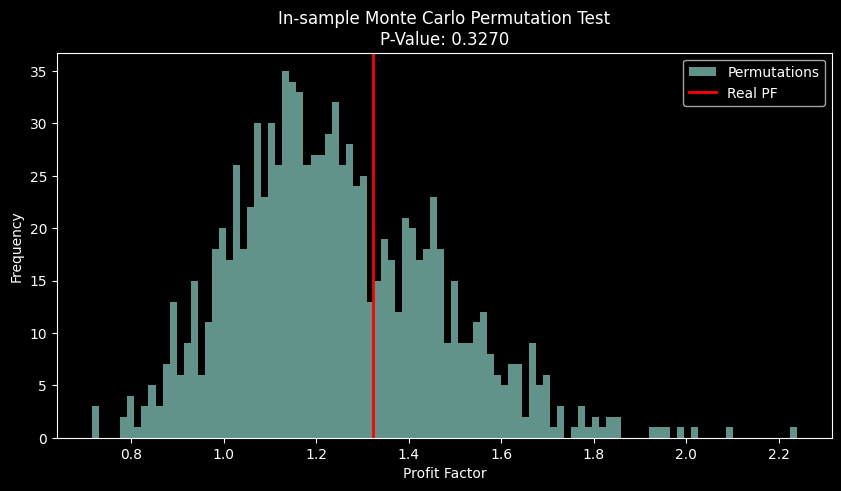

In [63]:
p_value, permuted_pfs, all_shuffled_preds = permutation_test_pf(
    data=data,
    best_prediction=best_prediction,
    training_len=training_len,
    n_permutations=1000
)